# Bitcoin Price Prediction Time-Series Project

## Import Modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import requests, json

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting  import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

from IPython.display import Markdown

from acquire import *
from prepare import *
from explore import *

In [2]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
Markdown(fetch_data_dict(df))

### Data Dict

| Feature           | Datatype                         | Definition                                                 |
|:------------------|:---------------------------------|:-----------------------------------------------------------|
| Timestamp         | 4857377 non-null: datetime64[ns] | start tiem of time window (60s window), in Unix Time       |
| Open              | 3613769 non-null: float64        | Open price at start time window                            |
| High              | 3613769 non-null: float64        | High price within the time window                          |
| Low               | 3613769 non-null: float64        | Low price within the time window                           |
| Close             | 3613769 non-null: float64        | Close price at the end of the time window                  |
| Volume_(BTC)      | 3613769 non-null: float64        | Volume of BTC transacted in this window                    |
| Volume_(Currency) | 3613769 non-null: float64        | Volume of corresponding currency transacted in this window |
| Weighted_Price    | 3613769 non-null: float64        | VWAP - Volume Weighted Average Price                       |

In [3]:
df = df.set_index('Timestamp')
result = '### Data Tail\n\n' + df.tail().to_markdown()
Markdown(result)

### Data Tail

| Timestamp           |    Open |    High |     Low |   Close |   Volume_(BTC) |   Volume_(Currency) |   Weighted_Price |
|:--------------------|--------:|--------:|--------:|--------:|---------------:|--------------------:|-----------------:|
| 2021-03-30 23:56:00 | 58714.3 | 58714.3 | 58686   | 58686   |       1.38449  |             81259.4 |          58692.8 |
| 2021-03-30 23:57:00 | 58684   | 58693.4 | 58684   | 58685.8 |       7.29485  |            428158   |          58693.2 |
| 2021-03-30 23:58:00 | 58693.4 | 58723.8 | 58693.4 | 58723.8 |       1.70568  |            100117   |          58696.2 |
| 2021-03-30 23:59:00 | 58742.2 | 58770.4 | 58742.2 | 58760.6 |       0.720415 |             42333   |          58761.9 |
| 2021-03-31 00:00:00 | 58767.8 | 58778.2 | 58756   | 58778.2 |       2.71283  |            159418   |          58764.3 |

### Prepare
> - This dataframe currenly has 4,857,377 rows and 8 columns
> - Creating more columns and resolving the null values with a `ffill` function seems to be the best option going forward.

In [4]:
df = prep_bitcoin_data(df)
new_data_dit = fetch_data_dict(df)

aggregation_functions = {'Open' : 'first', 'High': 'max', 'Low': 'min',
                         'Close': 'last', 'Volume_(BTC)': 'sum', 'Volume_(Currency)': 'sum',
                         'Weighted_Price' : 'mean', 'avg_price': 'mean'}

hourly = df.resample('H').agg(aggregation_functions)
hourly['hour'] = hourly.index.strftime('%H')
hourly = prep_bitcoin_data(hourly)
hourly.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,avg_price,hour,day_of_week,day_of_week_num,month,month_num,price_diff,price_delta,day_num,percent_change
Timestamp,,,,,,,,,,,,,,,,,
2021-03-30 20:00:00,59118.91,59135.00,58402.82,58669.04,118.576288,6.960580e+06,58682.385127,58893.975,20,Tuesday,1,03_Mar,3,-449.87,732.18,30,-0.760958
2021-03-30 21:00:00,58644.04,58872.27,58570.57,58759.04,57.605048,3.380143e+06,58705.094588,58701.540,21,Tuesday,1,03_Mar,3,115.00,301.70,30,0.196098
2021-03-30 22:00:00,58758.44,58941.34,58642.58,58711.15,68.019168,3.999820e+06,58788.454429,58734.795,22,Tuesday,1,03_Mar,3,-47.29,298.76,30,-0.080482
2021-03-30 23:00:00,58699.43,58770.38,58567.11,58760.59,81.032065,4.752543e+06,58665.780213,58730.010,23,Tuesday,1,03_Mar,3,61.16,203.27,30,0.104192
2021-03-31 00:00:00,58767.75,58778.18,58755.97,58778.18,2.712831,1.594178e+05,58764.349363,58772.965,00,Wednesday,2,03_Mar,3,10.43,22.21,31,0.017748


### New Data Dict

| Feature           | Datatype                  | Definition                                                 |
|:------------------|:--------------------------|:-----------------------------------------------------------|
| Open              | 4857377 non-null: float64 | Open price at start time window                            |
| High              | 4857377 non-null: float64 | High price within the time window                          |
| Low               | 4857377 non-null: float64 | Low price within the time window                           |
| Close             | 4857377 non-null: float64 | Close price at the end of the time window                  |
| Volume_(BTC)      | 4857377 non-null: float64 | Volume of BTC transacted in this window                    |
| Volume_(Currency) | 4857377 non-null: float64 | Volume of corresponding currency transacted in this window |
| Weighted_Price    | 4857377 non-null: float64 | VWAP - Volume Weighted Average Price                       |
| day_of_week       | 4857377 non-null: object  | Verbose name of the week                                   |
| month             | 4857377 non-null: object  | Month number and month name                                |
| minute_price_diff | 4857377 non-null: float64 | Delta between the Close and Open                           |
| price_delta       | 4857377 non-null: float64 | Delta between the High and Low                             |
| day_num           | 4857377 non-null: int64   | The numeric number of the day of the month                 |
| percent_change    | 4857377 non-null: float64 | Price difference / Open price represented as a percentage  |

### Prepare Takeaways

> - The additional columns will be helpful in breaking down the meterics and seeing if there are more cyclical trends to the Closing price of Bitcoin on any given hour.

### Explore


In [5]:
# split the data into train, validate, test
train, validate, test = time_split(hourly)
train.shape, validate.shape, test.shape

((40533, 17), (24319, 17), (16214, 17))

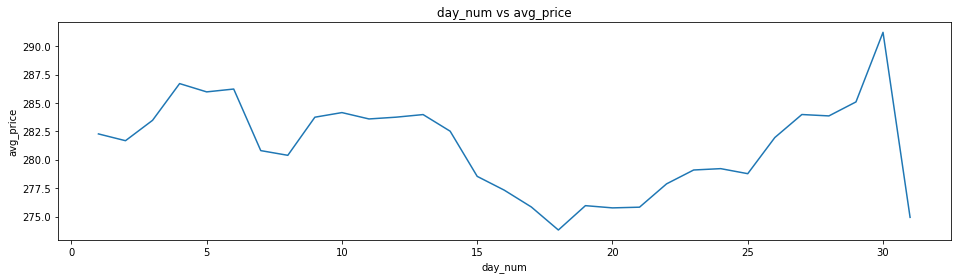

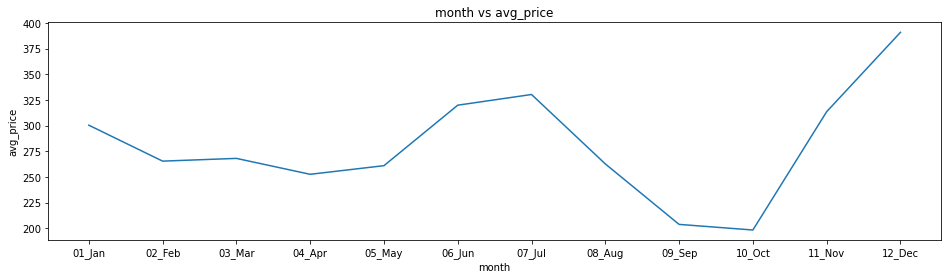

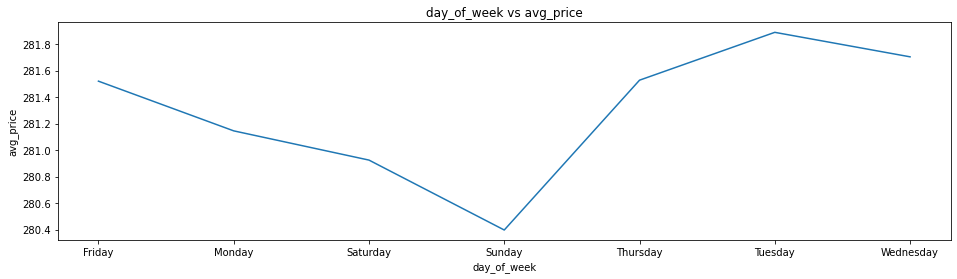

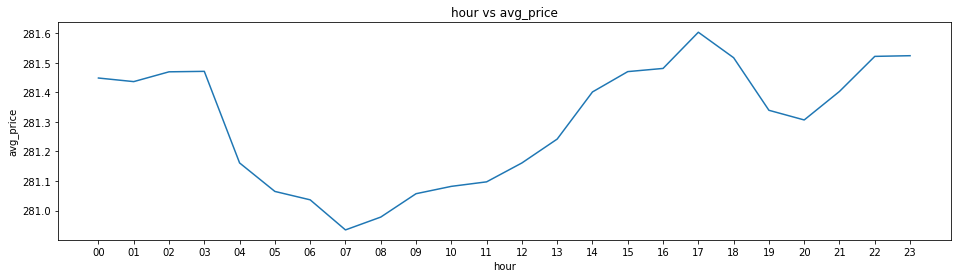

In [6]:
draw_lineplots(train, cols=['day_num', 'month', 'day_of_week', 'hour'],
               target='avg_price')

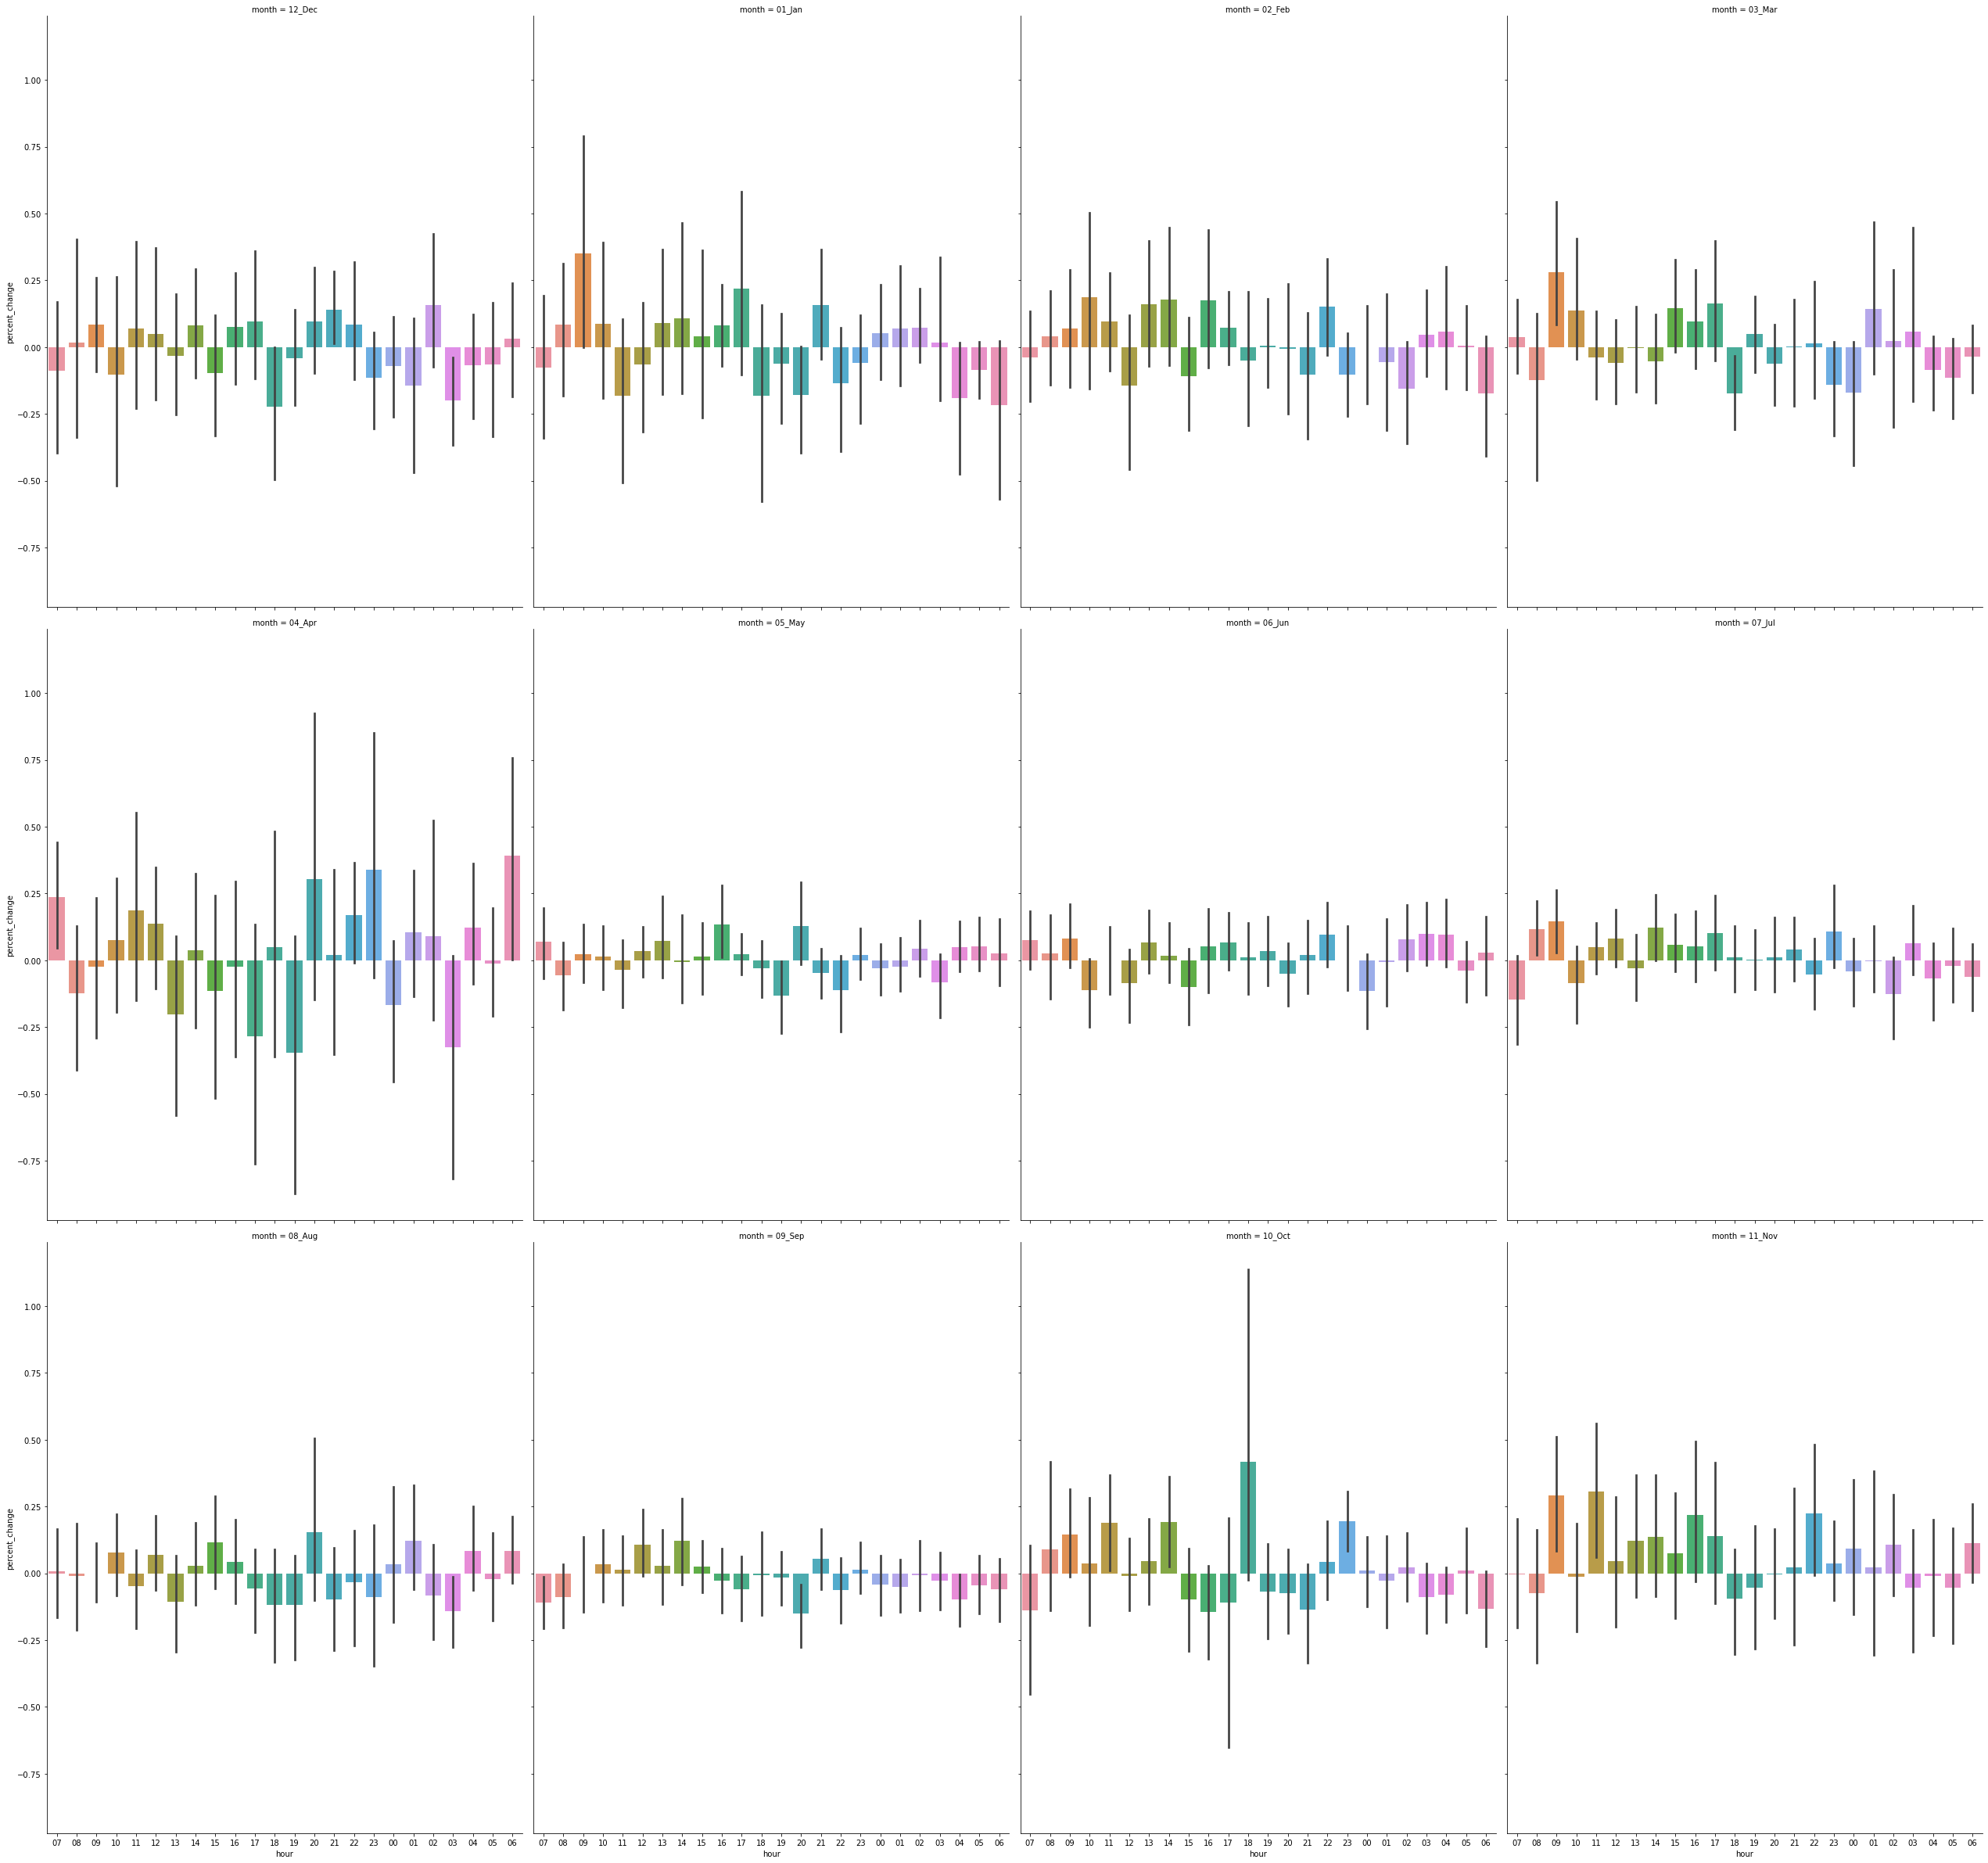

In [7]:
sns.catplot(x='hour', y='percent_change', col='month', data=train, kind='bar',
           aspect=.8, height=11, col_wrap=4)
plt.show()

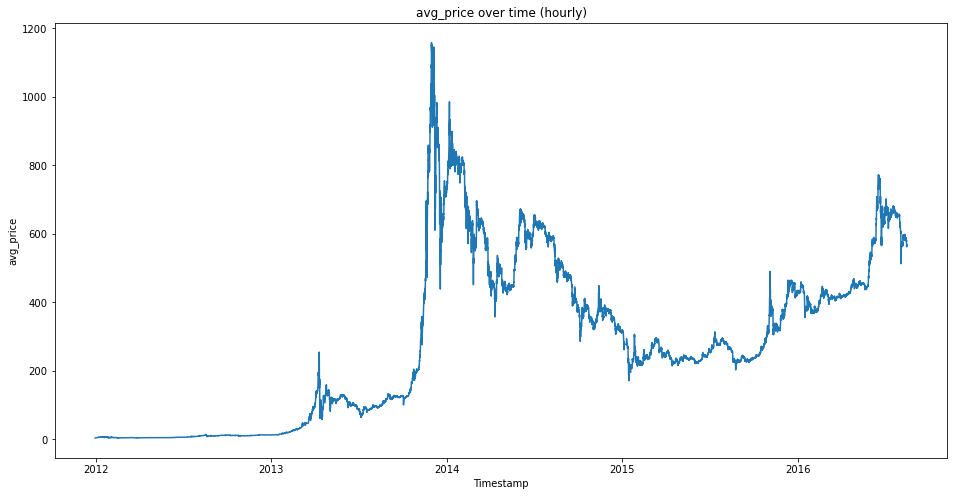

In [8]:
plt.figure(figsize=(16,8))
sns.lineplot(data=train['avg_price']).set(title='avg_price over time (hourly)')
plt.show()

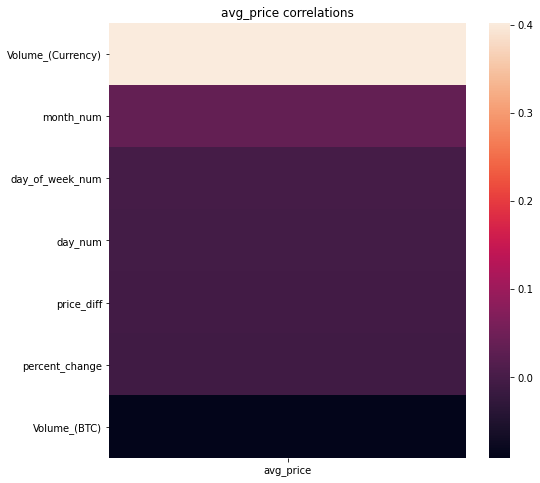

In [9]:
tmp = pd.DataFrame(train[[col for col in train.columns]].corr()['avg_price'].sort_values(ascending=False)[7:])
plt.figure(figsize=(8,8))
sns.heatmap(tmp).set(title='avg_price correlations')
plt.show()

In [10]:
print(tmp.to_markdown())

|                   |   avg_price |
|:------------------|------------:|
| Volume_(Currency) |  0.401821   |
| month_num         |  0.0343799  |
| day_of_week_num   | -0.00131061 |
| day_num           | -0.00386621 |
| price_diff        | -0.00489582 |
| percent_change    | -0.00803387 |
| Volume_(BTC)      | -0.0911557  |


### Explore Takeaways

> - It appears there is some correlation between Volume_(Currency), Volume_(BTC) and avg_price.
> - It also appears that the avg_price tends to trend upward during Oct, and downwards in Sept.

### Seasonal Decomposition

In [11]:
target = 'avg_price'
result = sm.tsa.seasonal_decompose(train[target])
decomp = pd.DataFrame({
    'y' : result.observed,
    'trend' : result.trend,
    'seasonal': result.seasonal,
    'resid' : result.resid,   
})
decomp.fillna(0).tail()

,y,trend,seasonal,resid
Timestamp,,,,
2016-08-14 23:00:00,568.305,0.0,0.138765,0.0
2016-08-15 00:00:00,567.330,0.0,0.049764,0.0
2016-08-15 01:00:00,566.170,0.0,0.024324,0.0
2016-08-15 02:00:00,566.095,0.0,0.043548,0.0
2016-08-15 03:00:00,567.590,0.0,0.030299,0.0


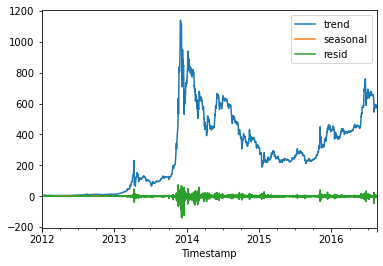

In [12]:
decomp.iloc[:, 1:].plot()
plt.show()

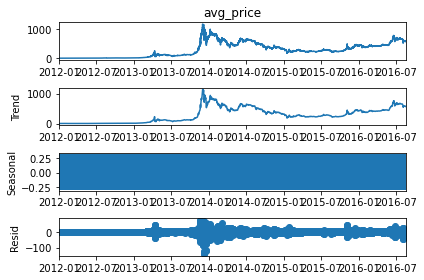

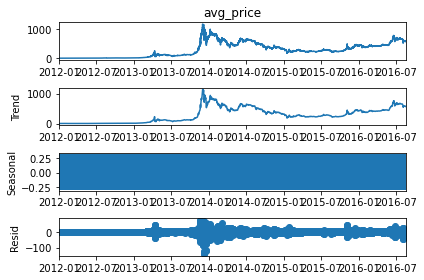

In [13]:
result.plot()

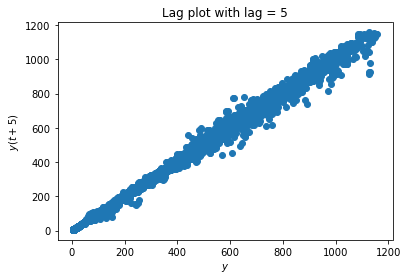

In [14]:
# Lag plot
# This is the lag amount
k = 5
plt.scatter(train[target], train[target].shift((k * -1)))
plt.xlabel('$y$')
plt.ylabel(f'$y (t + {k})$')
plt.title(f'Lag plot with lag = {k}')
plt.show()

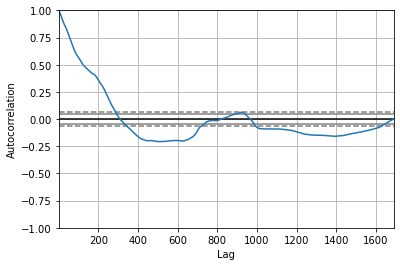

In [15]:
# Resample by daily and plot autocorrelation
pd.plotting.autocorrelation_plot(train.avg_price.resample('D').mean())
plt.show()

### Explore Takeaways
> - Bitcoin price has been strongly trending upwards consistently for years
> - October and December are months which typically have a large growth in the avg_price.
> - September and July are months that typically have a large downward trend in the avg_price.

## Modeling

In [16]:
def make_predictions(avg_temp):
    yhat_df = pd.DataFrame({'avg_price': [avg_temp]},
                          index = validate.index)
    return yhat_df
def plot_samples(target_var):
    '''
   plot each attribute 
   '''
    plt.figure(figsize = (12,4))
    sns.lineplot(data=train[target_var], label='train')
    sns.lineplot(data=validate[target_var], label='validate')
    sns.lineplot(data=test[target_var], label='test')
    plt.title(target_var.title())
    plt.legend()
    
def evaluate(target_var):
    '''
    the evaluate function will take in the actual values and the predicted values
    and compute the mean_squared_error and then take the sqrt returning a rounded rmse
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 5)
    return rmse

def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plot_samples(target_var)
    sns.lineplot(data=yhat_df[target_var], label='RMSE')
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, f'--RMSE: {rmse:.0f}')
    plt.show()

def append_eval_df(model_type, target_var):
    '''
    this function will take in the model type as a string, target variable
    as a string, and run the evaluate function to compute rmse, 
    and append to the dataframe a row with the model type, 
    target variable and rmse. 
    '''
    rmse = evaluate(target_var)
    d= {'model_type':[model_type], 'target_var':[target_var], 'rmse':[rmse]}
    d= pd.DataFrame(d)
    return eval_df.append(d, ignore_index= True)

def previous_plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    rmse = evaluate(target_var)
    print(target_var, f'--RMSE: {rmse:.0f}')
    return rmse

### Last Observed Value

In [17]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

test_cols = ['avg_price', 'percent_change']

avg_price =train.avg_price[-1]
percent_change = train.percent_change[-1]

yhat_df = pd.DataFrame({'avg_price': [avg_price],
                       'percent_change': [percent_change]},
                      index=validate.index)
yhat_df.head()

,avg_price,percent_change
Timestamp,,
2016-08-15 04:00:00,567.59,0.551208
2016-08-15 05:00:00,567.59,0.551208
2016-08-15 06:00:00,567.59,0.551208
2016-08-15 07:00:00,567.59,0.551208
2016-08-15 08:00:00,567.59,0.551208


avg_price --RMSE: 5633


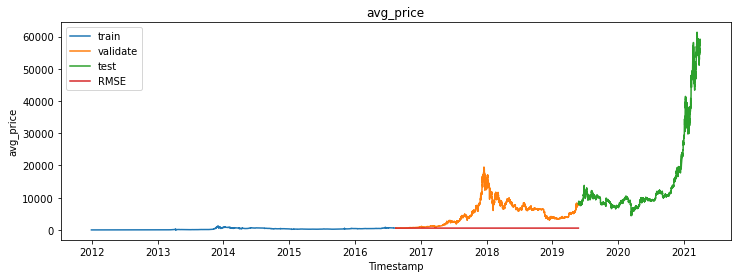

percent_change --RMSE: 1


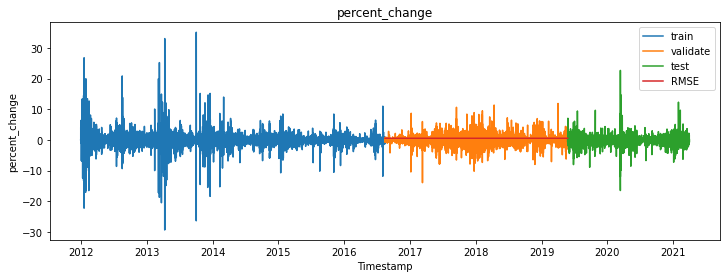

In [18]:
for col in test_cols:
    plot_and_eval(col)

In [19]:
for col in test_cols:
    eval_df = append_eval_df(model_type= 'last_observed_value',
                            target_var=col)
eval_df.head()

,model_type,target_var,rmse
0,last_observed_value,avg_price,5633.30825
1,last_observed_value,percent_change,1.07230


In [20]:
eval_df.head()

,model_type,target_var,rmse
0,last_observed_value,avg_price,5633.30825
1,last_observed_value,percent_change,1.07230


### Simple Average Model

In [21]:
avg_price = round(train.avg_price.mean(), 2)
percent_change = round(train.percent_change.mean(), 5)
yhat_df = pd.DataFrame(
    {
    'avg_price' : [avg_price],
    'percent_change' : [percent_change],
    },
    index=validate.index
)
yhat_df.head()

,avg_price,percent_change
Timestamp,,
2016-08-15 04:00:00,281.3,0.00975
2016-08-15 05:00:00,281.3,0.00975
2016-08-15 06:00:00,281.3,0.00975
2016-08-15 07:00:00,281.3,0.00975
2016-08-15 08:00:00,281.3,0.00975


avg_price --RMSE: 5855


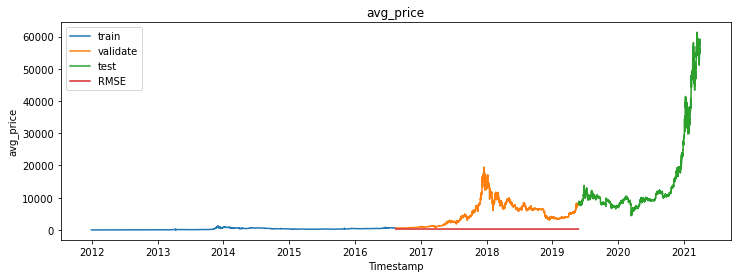

percent_change --RMSE: 1


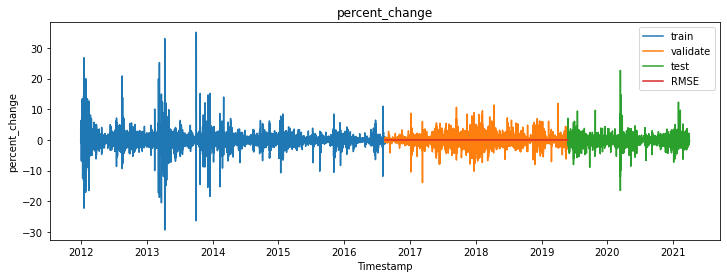

,model_type,target_var,rmse
0,last_observed_value,avg_price,5633.30825
1,last_observed_value,percent_change,1.07230
2,simple_average,avg_price,5855.22794
3,simple_average,percent_change,0.93091


In [22]:
for col in test_cols:
    plot_and_eval(col)
    
for col in test_cols:
    eval_df = append_eval_df(model_type= 'simple_average',
                             target_var=col)
    
eval_df

### Rolling/Moving Average Model

avg_price --RMSE: 5571


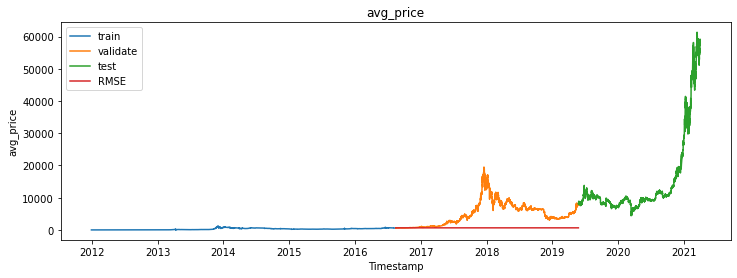

percent_change --RMSE: 1


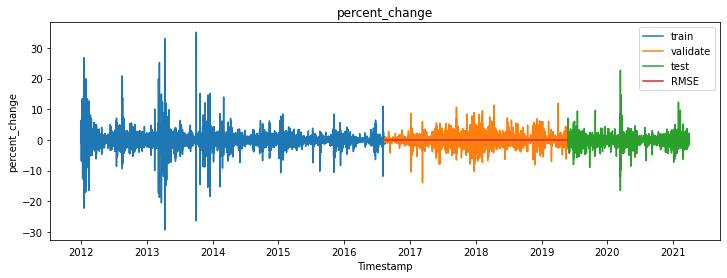

,model_type,target_var,rmse
0,last_observed_value,avg_price,5633.30825
1,last_observed_value,percent_change,1.07230
2,simple_average,avg_price,5855.22794
3,simple_average,percent_change,0.93091
4,moving_average_1502_hours,avg_price,5571.49375
5,moving_average_1502_hours,percent_change,0.93121


In [23]:
n = 1502 
avg_price = train.avg_price.rolling(n).mean().iloc[-1]
percent_change = train.percent_change.rolling(n).mean().iloc[-1]
yhat_df = pd.DataFrame(
    {
    'avg_price': [avg_price],
    'percent_change' : [percent_change],
    },
    index=validate.index
)

for col in test_cols:
    plot_and_eval(col)

for col in test_cols:
    eval_df = append_eval_df(model_type=f'moving_average_{n}_hours',target_var=col)

eval_df

### Holt's Linear Trend

avg_price


<Figure size 864x288 with 0 Axes>

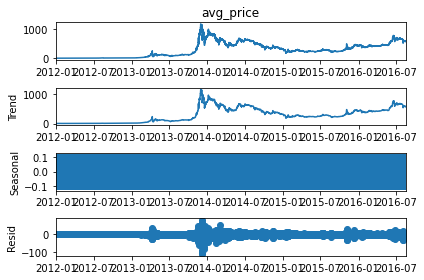

percent_change


<Figure size 864x288 with 0 Axes>

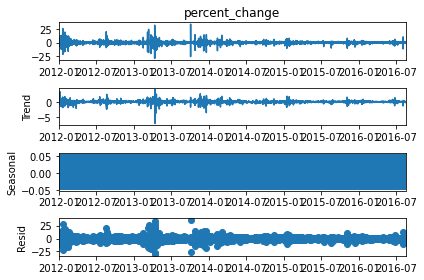

In [24]:
n = 12
for col in test_cols:
    print(col, end='\n')
    plt.figure(figsize=(12, 4))
    _ = sm.tsa.seasonal_decompose(train[col], period=n).plot()
    plt.show()

avg_price --RMSE: 53


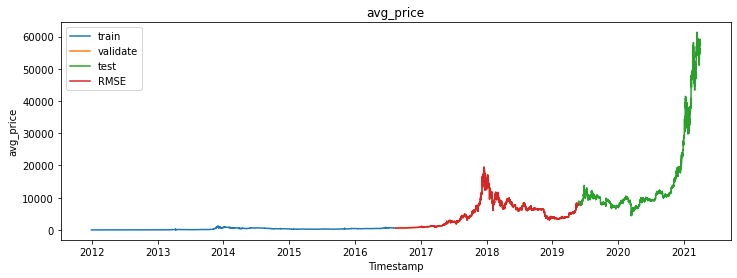

percent_change --RMSE: 1


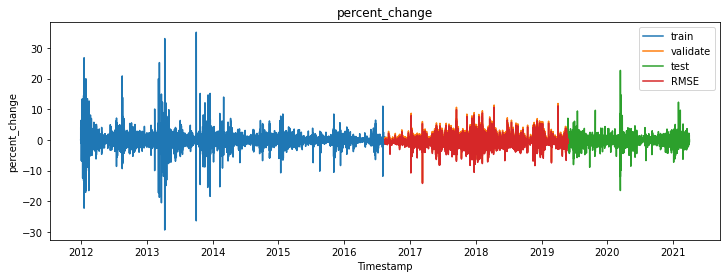

,model_type,target_var,rmse
0,last_observed_value,avg_price,5633.30825
1,last_observed_value,percent_change,1.07230
2,simple_average,avg_price,5855.22794
3,simple_average,percent_change,0.93091
4,moving_average_1502_hours,avg_price,5571.49375
5,moving_average_1502_hours,percent_change,0.93121
6,Holts,avg_price,53.06944
7,Holts,percent_change,1.43829


In [25]:

for col in test_cols:
    model = Holt(validate[col], exponential=False)
    # fit model
    model = model.fit(smoothing_level=.98,
                     smoothing_slope=0.0,
                     optimized=False)
    yhat = model.predict(start=validate.index[0],
                        end=validate.index[-1])
    yhat_df[col] = round(yhat, 2)

for col in test_cols:
    plot_and_eval(col)
    eval_df = append_eval_df(model_type = 'Holts',
                            target_var=col)
eval_df

### Previous Cycle

avg_price --RMSE: 647


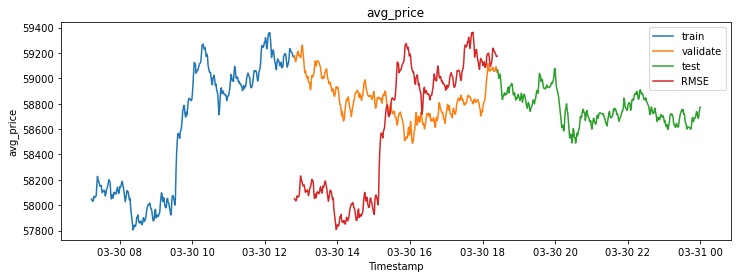

percent_change --RMSE: 0


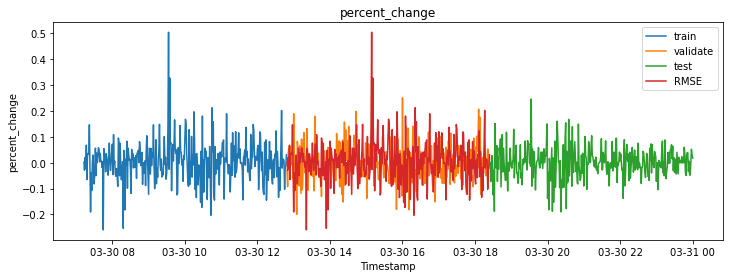

avg_price --RMSE: 782


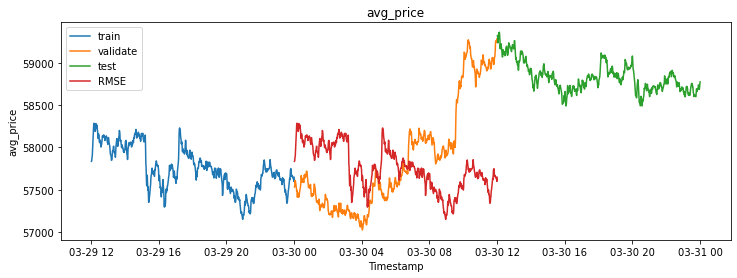

percent_change --RMSE: 0


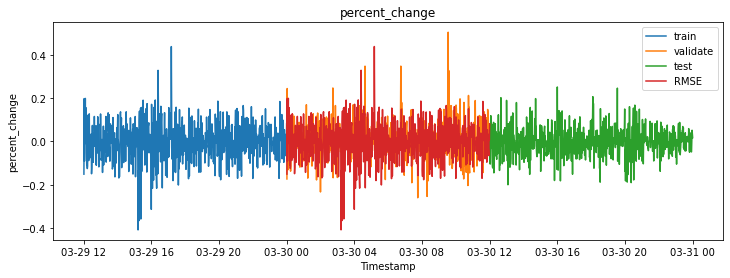

avg_price --RMSE: 1571


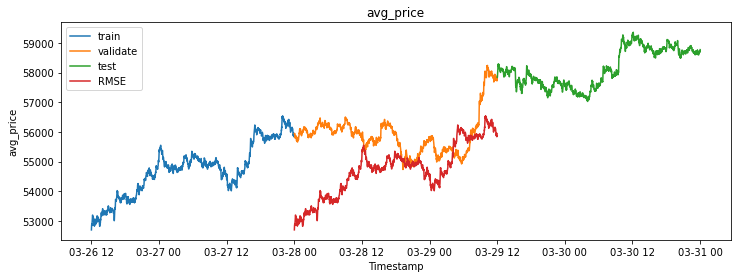

percent_change --RMSE: 0


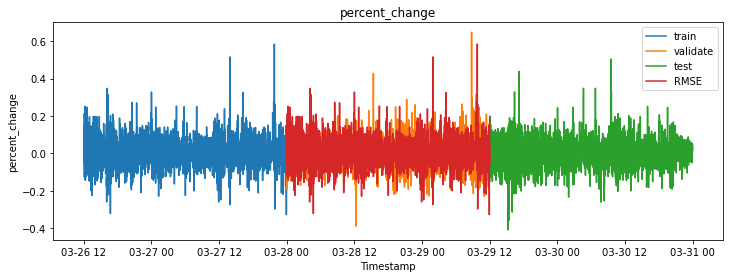

avg_price --RMSE: 3094


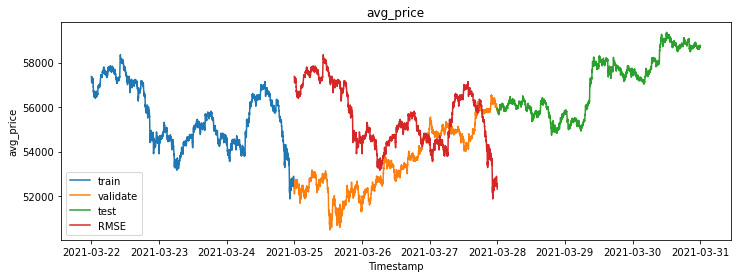

percent_change --RMSE: 0


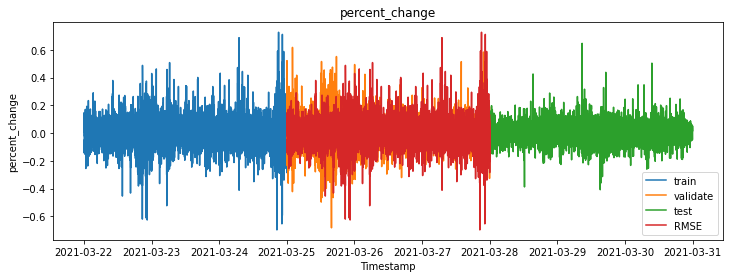

avg_price --RMSE: 2152


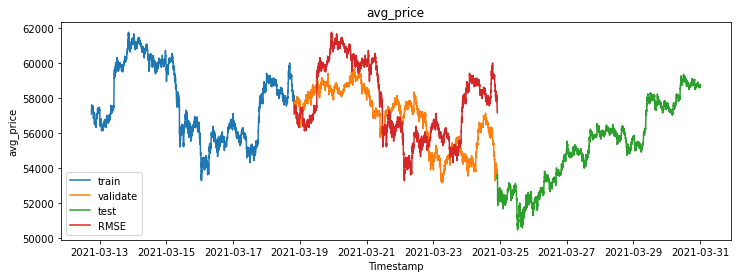

percent_change --RMSE: 0


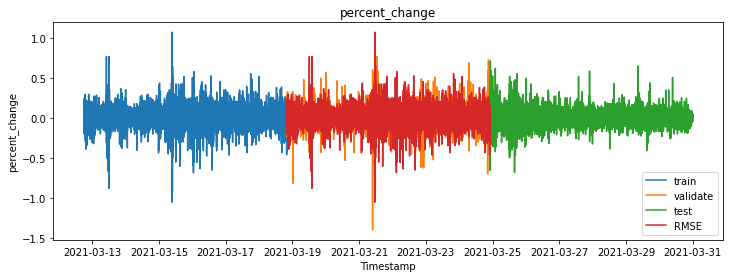

In [26]:
# 4320 is 6 months
cycles = {'2 weeks':336, '1 month':720, '3 months':2160, '6 months':4320, '1 year':8760}
for k,n in cycles.items():
    train = df.iloc[(n*3 * -1):(n*2*-1)]
    validate = df.iloc[(n*2*-1):(n*-1)]
    test = df.iloc[(n*-1):]
    
    yhat_df = train[['avg_price', 'percent_change']] + train[['avg_price', 'percent_change']].diff().mean()

    pd.concat([yhat_df.head(1), validate.head(1)])
    yhat_df.index = validate.index

    for col in test_cols:
        plot_and_eval(col)          
        eval_df = append_eval_df(model_type=f'previous {k}',
                                target_var=col)

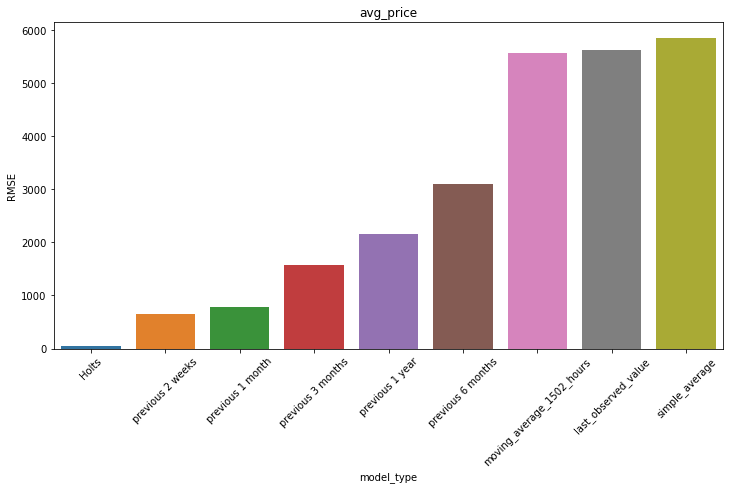

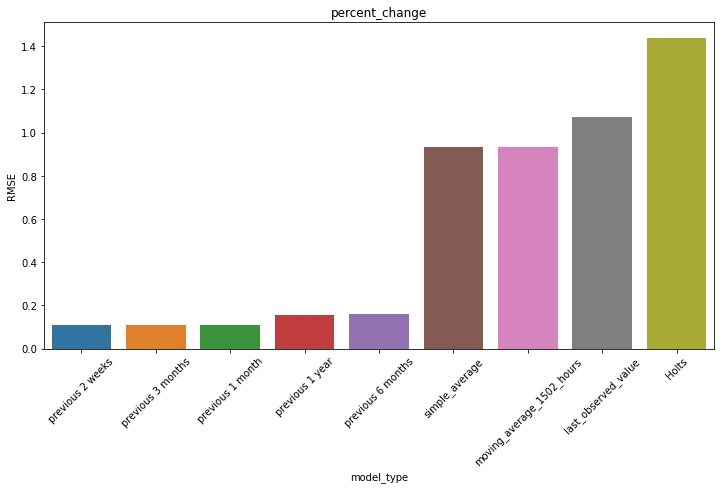

In [27]:
eval_df = eval_df.sort_values(by='rmse')
for col in test_cols:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show

In [29]:
print('The best performing model is:', eval_df[eval_df.target_var == 'avg_price'].model_type.iloc[0])
print('With an RMSE of:', eval_df[eval_df.target_var == 'avg_price'].rmse.iloc[0])

print('The best performing percent change model is:', eval_df[eval_df.target_var == 'percent_change'].model_type.iloc[0])
print('With an RMSE of:', eval_df[eval_df.target_var == 'percent_change'].rmse.iloc[0])

The best performing model is: Holts
With an RMSE of: 53.06944
The best performing percent change model is: previous 2 weeks
With an RMSE of: 0.1085
